
# 🎰 The Casino Challenge — Multi‑Armed Bandits & ε‑Greedy (Gamified Workshop)

**Goal:** Compete to maximize reward while learning the exploration–exploitation trade‑off using **ε‑greedy** policies.

**You will:**
- Implement and *play* with ε‑greedy on a fixed set of bandit arms (Round 1: Stationary).
- Compete on a leaderboard (submit your score locally).
- Reflect on how exploration affects performance.
- Face a twist (Round 2: **Non‑Stationary** bandits) and adapt your strategy.



## 🔧 Setup

Run the cell below. If you're on Colab/Jupyter, required libraries should already be available.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
from datetime import datetime

plt.rcParams['figure.figsize'] = (8, 4)

print("Numpy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)


Numpy: 2.1.3
Matplotlib: 3.10.3


In [2]:

def plot_cumulative(rewards, title="Cumulative Reward"):
    plt.figure()
    plt.plot(np.cumsum(rewards))
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    plt.show()



## 🎲 Environment: Stationary Bernoulli Bandits

Ten arms, each with a hidden probability of reward. You won't see the true means during play, but we print them here for **instructor debugging/analysis**. You may comment this out during the competition.


In [3]:

def make_stationary_bandit(n_arms=10, seed=42):
    rng = np.random.default_rng(seed)
    true_means = rng.random(n_arms)  # in [0,1)
    return true_means

# Instructor may reveal (comment out in live competition to keep secret)
SEED_ENV = 42  # 🔒 Keep this fixed across all students for fairness (Round 1)
TRUE_MEANS = make_stationary_bandit(seed=SEED_ENV)
print("DEBUG — True means (hidden in competition):", np.round(TRUE_MEANS, 3))


DEBUG — True means (hidden in competition): [0.774 0.439 0.859 0.697 0.094 0.976 0.761 0.786 0.128 0.45 ]



## 🤖 Agent: ε‑Greedy (Fixed or Decaying)

- With probability **ε**, explore a random arm.
- Otherwise, exploit the best arm found so far (highest estimated value).
- Estimates updated via **incremental sample average**.


In [4]:

def epsilon_greedy(true_means, steps=1000, epsilon=0.1, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)     # value estimates
    N = np.zeros(n_arms)     # counts
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        if rng.random() < epsilon:
            a = rng.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]  # incremental mean
        rewards[t] = r
        actions[t] = a
    return rewards, actions, Q, N

def epsilon_greedy_decaying(true_means, steps=1000, eps_start=0.5, eps_end=0.05, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)
    N = np.zeros(n_arms)
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        # Linear decay
        epsilon = eps_end + (eps_start - eps_end) * max(0, (steps - 1 - t)) / max(1, steps - 1)
        if rng.random() < epsilon:
            a = rng.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]
        rewards[t] = r
        actions[t] = a
    return rewards, actions, Q, N



# 🏁 Round 1 — Stationary Casino (Competition)

**Instructions**
1. Set your **NAME** and **STRATEGY**.
2. Choose **steps** and **ε** (or decaying ε parameters).
3. Run the simulation cell.
4. Submit to the local leaderboard (next cell).

> Everyone must use the same **SEED_ENV** to ensure the environment is identical. You can set your **agent seed** for reproducibility.



Player: Your Name
Strategy: epsilon_greedy (fixed_eps=0.1)
Steps: 2000
Total Reward: 1862
Estimated Best Arm: 5
Estimated Q: [0.729 0.52  0.923 0.75  0.095 0.973 0.783 0.857 0.19  0.143]
Counts N: [  48   25   26   24   21 1770   23   28   21   14]



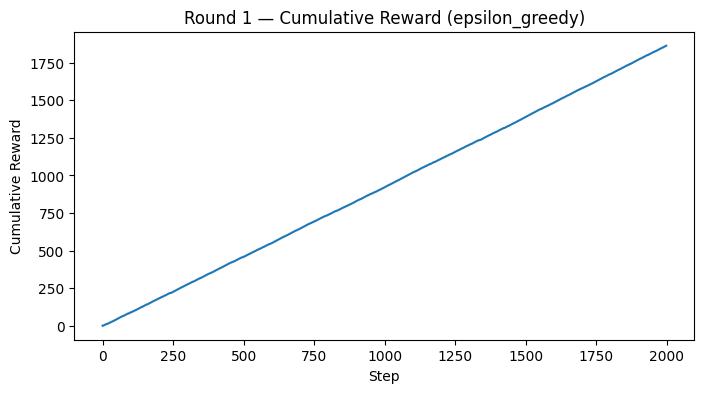

In [5]:

# === YOUR SETTINGS (edit) ===
NAME = "Your Name"
STRATEGY = "epsilon_greedy"  # options: "epsilon_greedy" or "epsilon_greedy_decaying"
STEPS = 2000

# For fixed ε
EPSILON = 0.1

# For decaying ε
EPS_START = 0.5
EPS_END = 0.05

# Agent RNG seed (can be None for randomness)
SEED_AGENT = 123

# === RUN ===
if STRATEGY == "epsilon_greedy":
    rewards, actions, Q, N = epsilon_greedy(TRUE_MEANS, steps=STEPS, epsilon=EPSILON, seed=SEED_AGENT)
    strat_desc = f"fixed_eps={EPSILON}"
elif STRATEGY == "epsilon_greedy_decaying":
    rewards, actions, Q, N = epsilon_greedy_decaying(TRUE_MEANS, steps=STEPS, eps_start=EPS_START, eps_end=EPS_END, seed=SEED_AGENT)
    strat_desc = f"decay_eps={EPS_START}->{EPS_END}"
else:
    raise ValueError("Unknown STRATEGY setting")

total = float(np.sum(rewards))
best_arm_est = int(np.argmax(Q))
print(f"""
Player: {NAME}
Strategy: {STRATEGY} ({strat_desc})
Steps: {STEPS}
Total Reward: {total:.0f}
Estimated Best Arm: {best_arm_est}
Estimated Q: {np.round(Q,3)}
Counts N: {N.astype(int)}
""")
plot_cumulative(rewards, title=f"Round 1 — Cumulative Reward ({STRATEGY})")



### 🧮 Submit to Leaderboard (Round 1)

This writes your result to a local CSV (`submissions_round1.csv`) in the current folder.  
The instructor can collect these files or run the next cell to view a local leaderboard.


In [6]:

import csv

lb_path = Path("submissions_round1.csv")
lb_exists = lb_path.exists()

row = {
    "timestamp": datetime.utcnow().isoformat(),
    "name": NAME,
    "strategy": STRATEGY,
    "details": strat_desc,
    "steps": STEPS,
    "seed_env": SEED_ENV,
    "seed_agent": SEED_AGENT,
    "total_reward": int(np.sum(rewards))
}

fieldnames = ["timestamp","name","strategy","details","steps","seed_env","seed_agent","total_reward"]

with open(lb_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not lb_exists:
        writer.writeheader()
    writer.writerow(row)

print("Submitted to", lb_path.resolve())


Submitted to D:\AI&ML-2\RL\MultiArmedBandit_Workshop\submissions_round1.csv


In [7]:
import pandas as pd
from IPython.display import display

lb_path = Path("submissions_round1.csv")

if lb_path.exists():
    df = pd.read_csv(lb_path)
    df_sorted = df.sort_values("total_reward", ascending=False).reset_index(drop=True)
    print("🏆 Round 1 Leaderboard (sorted by total reward):")
    display(df_sorted)
else:
    print("No submissions yet. Run the previous cell to submit your score.")


🏆 Round 1 Leaderboard (sorted by total reward):


,timestamp,name,strategy,details,steps,seed_env,seed_agent,total_reward
0,2025-10-17T21:42:43.786841,Your Name,epsilon_greedy,fixed_eps=0.1,2000,42,123,1862
1,2025-10-31T21:12:27.833645,Your Name,epsilon_greedy,fixed_eps=0.1,2000,42,123,1862



## 🧠 Step 6 — Reflect & Discuss (for your notes / debrief)

1. **What strategy did you use and why?**  
2. **How did ε influence your total reward?** Did you try multiple ε values?
3. **Did your agent get “stuck” exploiting too soon?** How could you prevent that?
4. **If you had more steps, what would you change (ε schedule, update rule, etc.)?**
5. **Compare with others:** Did randomness or design matter more for the winners?
6. **Transfer:** Where would this exploration dilemma appear in real systems (recsys, A/B testing, ads)?



## 📊 Experiment: Compare Different ε Values (Optional)

Run multiple ε settings to *see* the exploration trade‑off.


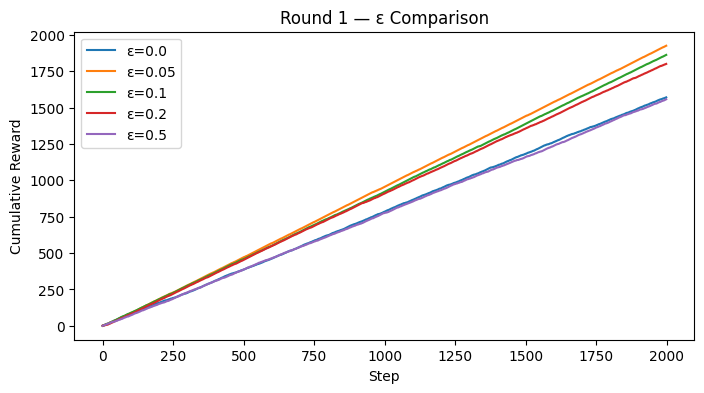

In [8]:

eps_list = [0.0, 0.05, 0.1, 0.2, 0.5]
curves = {}
for eps in eps_list:
    r, _, _, _ = epsilon_greedy(TRUE_MEANS, steps=STEPS, epsilon=eps, seed=SEED_AGENT)
    curves[eps] = np.cumsum(r)

plt.figure()
for eps, curve in curves.items():
    plt.plot(curve, label=f"ε={eps}")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Round 1 — ε Comparison")
plt.show()



# 🔄 Round 2 — Non‑Stationary Casino (Competition)

**Twist:** The slot machines drift over time. Fixed exploitation can fail; adaptive exploration helps.

Two common adaptations:
- Keep **ε** from decaying too low (retain exploration).
- Use a **constant step size α** (exponential moving average) to weight recent rewards more.


In [9]:

def nonstationary_means(n_arms=10, seed=2025):
    # Initialize random means
    rng = np.random.default_rng(seed)
    return rng.random(n_arms)

def step_drift(means, drift_scale=0.01, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    means = means + rng.normal(0, drift_scale, size=means.shape)
    return np.clip(means, 0.0, 1.0)

def epsilon_greedy_constant_alpha(steps=2000, n_arms=10, eps=0.1, alpha=0.1, seed_env=7, seed_agent=None, drift_scale=0.01):
    # Non-stationary env with drifting means
    rng_env = np.random.default_rng(seed_env)
    rng_agent = np.random.default_rng(seed_agent)
    means = rng_env.random(n_arms)
    Q = np.zeros(n_arms)
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        # choose action
        if rng_agent.random() < eps:
            a = rng_agent.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        # reward from current means
        r = 1.0 if rng_env.random() < means[a] else 0.0
        # constant step-size update (EMA)
        Q[a] = Q[a] + alpha * (r - Q[a])
        rewards[t] = r
        actions[t] = a
        # drift environment
        means = step_drift(means, drift_scale=drift_scale, rng=rng_env)
    return rewards, actions, Q



[Round 2]
Player: Your Name
Strategy: epsilon_greedy + constant_alpha (eps=0.1, alpha=0.1)
Steps: 3000
Total Reward: 2557



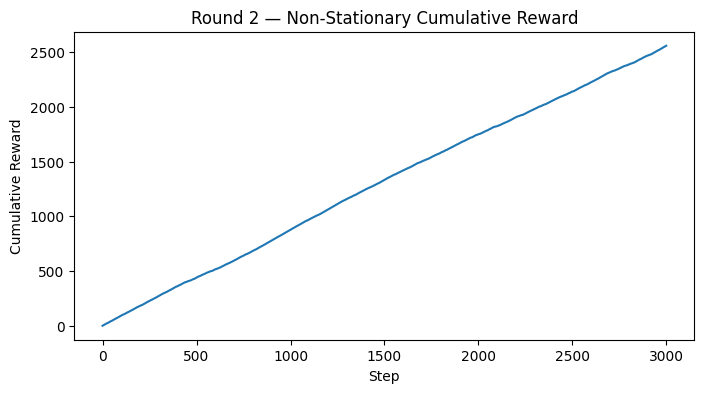

In [10]:

# === YOUR SETTINGS (edit) ===
NAME_R2 = "Your Name"
STEPS_R2 = 3000
EPS_R2 = 0.1     # keep some exploration alive
ALPHA_R2 = 0.1   # constant step size for non-stationarity
SEED_ENV_R2 = 2025  # shared across class
SEED_AGENT_R2 = 999
DRIFT_SCALE = 0.01  # magnitude of mean drift per step

# === RUN ===
rewards_r2, actions_r2, Q_r2 = epsilon_greedy_constant_alpha(
    steps=STEPS_R2, n_arms=10, eps=EPS_R2, alpha=ALPHA_R2,
    seed_env=SEED_ENV_R2, seed_agent=SEED_AGENT_R2, drift_scale=DRIFT_SCALE
)

total_r2 = int(np.sum(rewards_r2))
print(f"""
[Round 2]
Player: {NAME_R2}
Strategy: epsilon_greedy + constant_alpha (eps={EPS_R2}, alpha={ALPHA_R2})
Steps: {STEPS_R2}
Total Reward: {total_r2}
""")
plot_cumulative(rewards_r2, title="Round 2 — Non‑Stationary Cumulative Reward")


In [11]:

import csv
lb2_path = Path("submissions_round2.csv")
lb2_exists = lb2_path.exists()

row2 = {
    "timestamp": datetime.utcnow().isoformat(),
    "name": NAME_R2,
    "strategy": f"eps={EPS_R2}, alpha={ALPHA_R2}",
    "steps": STEPS_R2,
    "seed_env": SEED_ENV_R2,
    "seed_agent": SEED_AGENT_R2,
    "drift_scale": DRIFT_SCALE,
    "total_reward": total_r2
}

fieldnames2 = ["timestamp","name","strategy","steps","seed_env","seed_agent","drift_scale","total_reward"]

with open(lb2_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames2)
    if not lb2_exists:
        writer.writeheader()
    writer.writerow(row2)

print("Submitted to", lb2_path.resolve())


Submitted to D:\AI&ML-2\RL\MultiArmedBandit_Workshop\submissions_round2.csv


In [12]:
import pandas as pd
from IPython.display import display

lb_path = Path("submissions_round2.csv")

if lb_path.exists():
    df = pd.read_csv(lb_path)
    df_sorted = df.sort_values("total_reward", ascending=False).reset_index(drop=True)
    print("🏆 Round 1 Leaderboard (sorted by total reward):")
    display(df_sorted)
else:
    print("No submissions yet. Run the previous cell to submit your score.")


🏆 Round 1 Leaderboard (sorted by total reward):


,timestamp,name,strategy,steps,seed_env,seed_agent,drift_scale,total_reward
0,2025-10-17T21:44:32.136946,Your Name,"eps=0.1, alpha=0.1",3000,2025,999,0.01,2557
1,2025-10-31T21:12:33.125052,Your Name,"eps=0.1, alpha=0.1",3000,2025,999,0.01,2557



## 🧪 Bonus (Optional): Compete with UCB or Thompson Sampling

If allowed by the instructor, try implementing:
- **UCB1 (Upper Confidence Bound):** add an optimism bonus to less‑tried arms.
- **Thompson Sampling:** maintain Beta posteriors for each arm and sample to choose.

> Keep Round 1/2 seeds the same for comparability.



---

### ✅ Submission Notes for Instructors
- Each student’s notebook writes a local CSV (`submissions_round1.csv` / `submissions_round2.csv`).  
  Collect these files or ask students to paste rows into a shared sheet for a class-wide leaderboard.
- **Fairness:** Keep `SEED_ENV` (Round 1) and `SEED_ENV_R2` (Round 2) fixed across all students.
- **Assessment Ideas:** Award badges like *Risk Taker* (highest ε with solid score), *Efficient Exploiter*, *Adaptive Strategist* (best in Round 2).

### 🧠 Learning Outcomes
- Understand & visualize the exploration–exploitation trade‑off.
- See why ε matters, and why **constant‑α** helps in non‑stationary settings.
- Practice experimental design (controlled seeds, fair comparisons, parameter sweeps).

Happy bandit hunting! 🎲


### Talking points by companring both the csv files 

| **Aspect** | **Round 1 (submissions_round1.csv)** | **Round 2 (submissions_round2.csv)** | **Talking Point / Insight** |
|-------------|--------------------------------------|--------------------------------------|------------------------------|
| **File Size / Shape** | 2 rows × 8 columns | 2 rows × 8 columns | Both rounds have the same structure, showing consistent experiment design. |
| **Common Columns** | timestamp, name, strategy, steps, seed_env, seed_agent, total_reward | timestamp, name, strategy, steps, seed_env, seed_agent, total_reward | Both contain core metrics for tracking model performance and reproducibility. |
| **Unique Column** | details | drift_scale | Round 1 focused on experiment description, while Round 2 added a new parameter (`drift_scale`) to test environmental variation. |
| **Average Total Reward** | **1862.0** | **2557.0** | Round 2 shows a higher average reward, suggesting improved performance or better adaptation of the strategy. |
| **Goal Difference** | Likely baseline or initial setup testing | Likely drift or adaptation testing | Round 2 appears to extend Round 1 by introducing drift to study how strategies adapt. |
| **Overall Observation** | Basic setup and documentation | Refined version introducing variability | The experiment evolved from explaining details to testing robustness and adaptability. |


### Summary

It’s like you’re playing in a **casino** 🎰 where there are many machines (called *bandits*).  
Each machine gives you some **reward** (like coins) when you pull its lever, but you don’t know which one gives the most.  
So, your notebook teaches a **smart player (agent)** how to try each machine, learn which one pays more, and then keep choosing the best one over time.  
This learning process is called the **Multi-Armed Bandit (MAB)** problem.  
The goal is to **win as many rewards as possible** by learning from experience — not just guessing!  


###  Overall Talking Points

-  The **Casino Challenge** notebook is based on the **Multi-Armed Bandit (MAB)** problem — like choosing the best slot machine in a casino to win more rewards.  
- The notebook trains a smart **agent** to learn which machine gives better rewards by trying, learning, and improving over time.  
-  The goal is to **maximize total rewards** through experience instead of random guessing.  
-  Two CSV files — **Round 1** and **Round 2** — record experiment results and help track progress.  
-  Both files have a similar structure, but **Round 2** adds a new parameter `drift_scale` instead of `details`, showing an experiment upgrade.  
-  The **average reward** increased from **1862.0** (Round 1) to **2557.0** (Round 2), proving better performance and smarter decision-making by the agent.  
-  Overall, the experiment shows how the agent becomes more intelligent over time, adapting to new conditions and improving its results.
